In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [17]:
from math import comb


IGNORE_LIST = ('saycam_split_text_test.csv', 'saycam_nan_test.csv')
CORRECT_KEY = 'containment_high_containment_cos'
INCORRECT_KEYS = ['containment_behind_cos', 'containment_support_cos']
ORDERED_COLUMNS = ['model', 'training', 'flip', 'dino', 'image_index', 'bowl_color', 'target_object', 
        'containment_high_containment_cos', 'containment_behind_cos', 'containment_support_cos',
        'high_containment_behind_cos', 'high_containment_support_cos', 'behind_support_cos', 
        'correct', 'cos_ratio', 'cos_diff']
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'Robot', 'RubberDuck', 'Teddy', 'Truck']


def load_and_join_dataframes(folder: str, ext: str = '.csv', ignore_list: typing.Sequence[str] = IGNORE_LIST) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def add_target_object_field(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(target_object=[TARGET_OBJECTS[i % len(TARGET_OBJECTS)] for i in df.image_index])


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    correct = []
    cos_ratio = []
    cos_diff = []

    for _, row in df.iterrows():    
        correct_val = row[correct_key]
        max_incorrect_val = max([row[k] for k in incorrect_keys])  # type: ignore

        correct.append(correct_val >= max_incorrect_val)
        cos_ratio.append(correct_val / max_incorrect_val)
        cos_diff.append(correct_val - max_incorrect_val)

    return df.assign(correct=correct, cos_ratio=cos_ratio, cos_diff=cos_diff)

    
combined_df = load_and_join_dataframes('../containment_support_outputs')
combined_df.drop(columns=[combined_df.columns[0]], inplace=True)  # type: ignore
combined_df = parse_model_name(combined_df)
combined_df = combined_df.rename(columns={'index': 'image_index'})
combined_df = add_target_object_field(combined_df)
combined_df = evaluate_accuracy(combined_df)

combined_df = combined_df[ORDERED_COLUMNS]
print(combined_df.shape)
combined_df.head()

(12288, 16)


,model,training,flip,dino,image_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
0,resnext,saycam(S)-flip,s,None,0,brown,BeachBall,0.821403,0.827495,0.846809,0.928499,0.909522,0.974116,False,0.969998,-0.025406
1,resnext,saycam(S)-flip,s,None,1,blue,Knight,0.856041,0.829619,0.841452,0.944829,0.912327,0.954147,True,1.017338,0.014589
2,resnext,saycam(S)-flip,s,None,2,purple,Lego,0.838563,0.838034,0.814633,0.952457,0.899645,0.939837,True,1.000631,0.000529
3,resnext,saycam(S)-flip,s,None,3,green,Pineapple,0.817329,0.808149,0.797166,0.935150,0.886878,0.955024,True,1.011358,0.009179
4,resnext,saycam(S)-flip,s,None,4,brown,Robot,0.828670,0.791044,0.763196,0.904463,0.852929,0.949094,True,1.047565,0.037626


In [21]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'acc_mean',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy',
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df[plot_field].mean()

    if compute_std:
        std = grouped_df[plot_field].std()
        if sem:
            std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
    
    else:
        if sem:
            std = grouped_df.acc_sem.mean()
        else:
            std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        for i, panel_value in enumerate(orders_by_field[panel_by]):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, mean[panel_value], std[panel_value],
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, 
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_rows == 0 else '')

            else:
                plot_single_panel(panel_ax, mean[panel_value], std[panel_value], 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_rows == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            title = f'{panel_by} = {panel_value}'
            if panel_titles is not None:
                title = panel_titles[i]
                
            panel_ax.set_title(title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [5]:
combined_df.model.unique()

array(['resnext', 'mobilenet'], dtype=object)

In [6]:
combined_df.head()

,model,training,flip,dino,image_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct
0,resnext,saycam(S)-flip,s,None,0,brown,BeachBall,0.821403,0.827495,0.846809,0.928499,0.909522,0.974116,0
1,resnext,saycam(S)-flip,s,None,1,blue,Knight,0.856041,0.829619,0.841452,0.944829,0.912327,0.954147,1
2,resnext,saycam(S)-flip,s,None,2,purple,Lego,0.838563,0.838034,0.814633,0.952457,0.899645,0.939837,1
3,resnext,saycam(S)-flip,s,None,3,green,Pineapple,0.817329,0.808149,0.797166,0.935150,0.886878,0.955024,1
4,resnext,saycam(S)-flip,s,None,4,brown,Robot,0.828670,0.791044,0.763196,0.904463,0.852929,0.949094,1


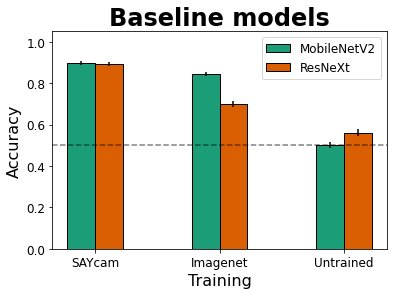

In [7]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Baseline models',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

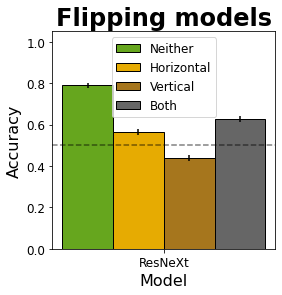

In [8]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Flipping models',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

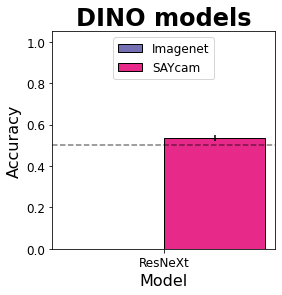

In [9]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='DINO models',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [10]:
filter_and_group(combined_df, dict(training='DINO'), ['model', 'dino']).correct.mean()

model    dino     
resnext  ImageNet     0.00000
         saycam(S)    0.53418
Name: correct, dtype: float64

In [11]:
combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_24128/3096591689.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']


,model,training,flip,dino,image_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct
11264,resnext,DINO,None,ImageNet,0,brown,BeachBall,0.839141,0.875026,0.881289,0.948535,0.945324,0.967396,0
11265,resnext,DINO,None,ImageNet,1,blue,Knight,0.884040,0.877565,0.898226,0.957285,0.927317,0.949506,0
11266,resnext,DINO,None,ImageNet,2,purple,Lego,0.807176,0.862019,0.840312,0.930387,0.904878,0.941243,0
11267,resnext,DINO,None,ImageNet,3,green,Pineapple,0.849684,0.867118,0.884284,0.958636,0.912403,0.945931,0
11268,resnext,DINO,None,ImageNet,4,brown,Robot,0.851729,0.868783,0.868985,0.934821,0.905083,0.944743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12283,resnext,DINO,None,ImageNet,1019,green,Pineapple,0.836444,0.861583,0.873542,0.954927,0.905369,0.946470,0
12284,resnext,DINO,None,ImageNet,1020,brown,Robot,0.839658,0.866353,0.863785,0.929928,0.903461,0.947949,0
12285,resnext,DINO,None,ImageNet,1021,blue,RubberDuck,0.846208,0.879867,0.883563,0.945256,0.910593,0.961684,0
12286,resnext,DINO,None,ImageNet,1022,purple,Teddy,0.824687,0.885994,0.863791,0.928199,0.881619,0.945410,0


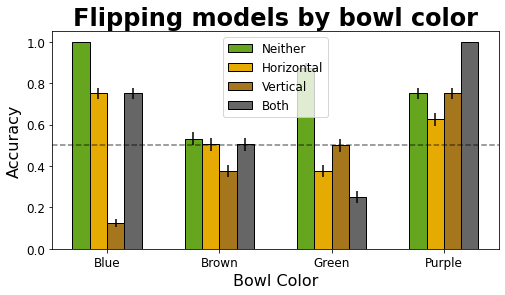

In [12]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Flipping models by bowl color',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

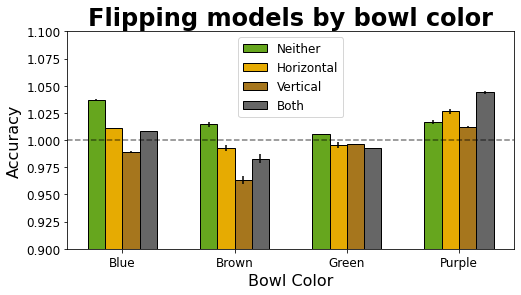

In [24]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Flipping models by bowl color',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

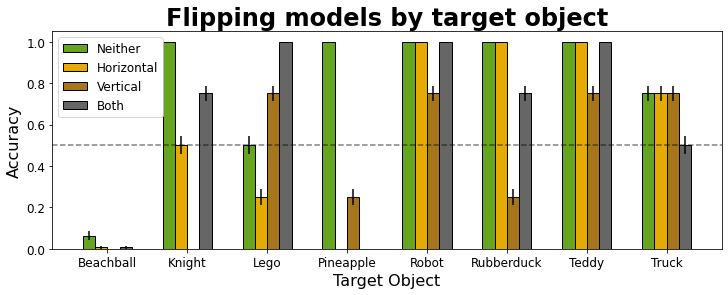

In [25]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Flipping models by target object',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

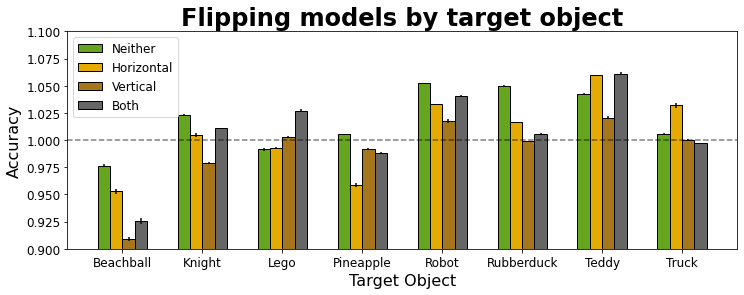

In [28]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles='Flipping models by target object',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [15]:
gfdf = filter_and_group(combined_df, dict(training='saycam(S)-flip'), ['target_object', 'flip'])

gfdf.mean()

image_index  containment_high_containment_cos  \
target_object flip                                                  
BeachBall     h           508.0                          0.790519   
              hv          508.0                          0.657875   
              s           508.0                          0.750011   
              v           508.0                          0.653769   
Knight        h           509.0                          0.836916   
              hv          509.0                          0.835988   
              s           509.0                          0.848223   
              v           509.0                          0.899976   
Lego          h           510.0                          0.861858   
              hv          510.0                          0.861413   
              s           510.0                          0.817858   
              v           510.0                          0.892726   
Pineapple     h           511.0                          0.793550   
              hv          511.0                          0.805812   
              s           511.0                          0.803401   
              v           511.0                          0.878362   
Robot         h           512.0                          0.834780   
              hv          512.0                          0.813348   
              s           512.0                          0.819943   
              v           512.0                          0.879401   
RubberDuck    h           513.0                          0.854557   
              hv          513.0                          0.838427   
              s           513.0                          0.840236   
              v           513.0                          0.889621   
Teddy         h           514.0                          0.860824   
              hv          514.0                          0.837728   
              s           514.0                          0.849598   
              v           514.0                          0.882628   
Truck         h           515.0                          0.847876   
              hv          515.0                          0.822411   
              s           515.0                          0.826747   
              v           515.0                          0.881529   

                    containment_behind_cos  containment_support_cos  \
target_object flip                                                    
BeachBall     h                   0.795165                 0.829344   
              hv                  0.666153                 0.710525   
              s                   0.760249                 0.766329   
              v                   0.680219                 0.718284   
Knight        h                   0.831154                 0.832465   
              hv                  0.825940                 0.823812   
              s                   0.824675                 0.828637   
              v                   0.915859                 0.919541   
Lego          h                   0.845930                 0.867812   
              hv                  0.828256                 0.838851   
              s                   0.824828                 0.797690   
              v                   0.889901                 0.872743   
Pineapple     h                   0.812936                 0.827579   
              hv                  0.815382                 0.789873   
              s                   0.798969                 0.790114   
              v                   0.881117                 0.884784   
Robot         h                   0.808085                 0.798911   
              hv                  0.781676                 0.772487   
              s                   0.779114                 0.761020   
              v                   0.850738                 0.864506   
RubberDuck    h                   0.831589                 0.840568   
              hv                  0.8183